**Step # 1: Installing Required Libraries**

---



**Education Assistant**
---
This is a Education Assistant that can answer questions from English , Math and Science subjects for School / College Students

In [ ]:
# Installing the Required Libraries
%%capture --no-stderr
pip install langgraph langchain_core langchain_google_genai python-dotenv tavily-python langchain_community


**Step # 2: Importing Packages**

---

In [ ]:
# Importing Packages
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

#########################################
from langgraph.checkpoint.memory import MemorySaver
#########################################

# Importing Packages for the Image Display
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os


from langgraph.graph.state import CompiledStateGraph

**Step # 3: Load Environment Variables and Set API Keys**

---

In [ ]:
# Load environment variables and set API key
load_dotenv()

from google.colab import userdata
os.environ["GEMINI_API_KEY"]=userdata.get('GEMINI_API_KEY')


**Step # 4 : Define State Structure**

---

In [ ]:
# Define State Structure
from typing_extensions import Annotated
from langgraph.graph import add_messages
from langchain_core.messages import AnyMessage

class State(TypedDict):
    query: str
    category: str
    response: str
    messages: Annotated[list[AnyMessage], add_messages]

#######################################
#    query: str
#    category: str
#    response: str
#    messages: Annotated[list[AnyMessage], add_messages]
######################################


**Memory Persistance**
-------------------
LangGraph implements a built-in persistence layer, making it ideal for chat applications that support multiple conversational turns. LangGraph comes with a simple in-memory checkpointer, which is *MemorySaver*. It is an in-memory checkpoint saver to stores checkpoints in memory using a defaultdict.

**Note:**
Only use *MemorySaver* for debugging or testing purposes. For production it is recommended to use different persistence backends e.g., SQLite or Postgres. For example we can use langgraph-checkpoint-postgres and using PostgresSaver / AsyncPostgresSaver for Postgres database.

In [ ]:

memory: MemorySaver = MemorySaver()

# Specify a thread
config1 = {"configurable": {"thread_id": "1"}}

**Step # 5 : Define Function Nodes**

---

In [ ]:
#  Define the functions/nodes
def categorize(state: State) -> State:
    """Categorize the user query into English, Math or Science."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories: "
        "English, Math or Science. Query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(temperature=0,model="gemini-2.0-flash-exp",api_key=userdata.get('GEMINI_API_KEY'))
    category = chain.invoke({"query": state["query"]},config1).content
    return {"category": category}

def handle_english(state: State) -> State:
    """Provide a English Language related response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a english language related response to the following user query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(temperature=0,model="gemini-2.0-flash-exp",api_key=userdata.get('GEMINI_API_KEY'))
    response = chain.invoke({"query": state["query"]},config1).content
    return {"response": response}

def handle_math(state: State) -> State:
    """Provide a Math related response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a Math related response to the following user query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(temperature=0,model="gemini-2.0-flash-exp",api_key=userdata.get('GEMINI_API_KEY'))
    response = chain.invoke({"query": state["query"]},config1).content
    return {"response": response}

def handle_science(state: State) -> State:
    """Provide a Science related to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a Science related response to the following user query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(temperature=0,model="gemini-2.0-flash-exp",api_key=userdata.get('GEMINI_API_KEY'))
    response = chain.invoke({"query": state["query"]},config1).content
    return {"response": response}

def route_query(state: State) -> str:
    """Route the query based on its category."""
    if state["category"] == "English":
        return "handle_english"
    elif state["category"] == "Math":
        return "handle_math"
    else:
        return "handle_science"

**Step # 6 : Define Graph , Add Nodes , Specify Route and Compile Graph**

---

In [ ]:
# Create the graph
graph = StateGraph(State)

# Add nodes
graph.add_node("categorize", categorize)
graph.add_node("handle_english", handle_english)
graph.add_node("handle_math", handle_math)
graph.add_node("handle_science", handle_science)


# Add edges
graph.add_edge(START, "categorize")
graph.add_conditional_edges(
    "categorize",
    route_query,
    {
        "handle_english": "handle_english",
        "handle_math": "handle_math",
        "handle_science": "handle_science",
    }
)
graph.add_edge("handle_english", END)
graph.add_edge("handle_math", END)
graph.add_edge("handle_science", END)



app: CompiledStateGraph = graph.compile(checkpointer=memory)



**Step # 7 : Display Graph / Visual Representation**

---

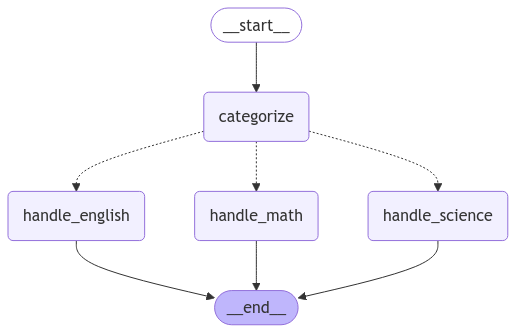

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

**Step # 8 : Define Function To Test the Graph Working**

---

In [ ]:
# Define Function to Test the Working


def run_test_function(query: str) -> Dict[str, str]:
    """Process User query through the LLM and LangGraph .

    Args:
        query (str): The user's query

    Returns:
        Dict[str, str]: A dictionary containing the query's Category and Response
    """
    results = app.invoke({"query": query},config1)

    return {
        "category": results["category"],
        "response": results["response"]
    }


**Step # 9 : Define the Program that takes Continous Inputs and Process User Query**

---

In [ ]:
# Define the Program to take user inputs till user types exit
def main():
    while True:
        query = input("Please enter your query (or type 'exit' to quit): ")
        if query.lower() == 'exit':
            print("Goodbye!")
            break

        result = run_test_function(query)
        print(f"Query: {query}")
        print(f"Category: {result['category']}")
        print(f"Response: {result['response']}")
        print("\n")

if __name__ == "__main__":
    main()


Query: What is gravity
Category: **Science**
Response: Okay, let's break down gravity from a scientific perspective.

**Gravity: A Fundamental Force**

Gravity is one of the four fundamental forces in the universe (the others being electromagnetism, the strong nuclear force, and the weak nuclear force). It's the force of attraction between any two objects with mass. This means that *everything* with mass exerts a gravitational pull on everything else with mass.

**Key Concepts:**

* **Mass:** The amount of "stuff" an object is made of. The more mass an object has, the stronger its gravitational pull.
* **Attraction:** Gravity is always an attractive force; it pulls objects together, never pushes them apart.
* **Distance:** The strength of gravity decreases rapidly with distance. The farther apart two objects are, the weaker the gravitational force between them.

**Newton's Law of Universal Gravitation:**

Sir Isaac Newton formulated a law that describes the gravitational force between 